# Assignment 1: Monte Carlo
In this assignment you will build a python code to calculate the pressure of methane as function of density and temperature, not only for gaseous methane, but also for liquid and supercritical methane.


Monte Carlo (MC) simulations allow for computing thermodynamic properties by sampling random configurations of the system. During lectures, you learned about the theory behind MC simulations. In this assignment, you will create your own MC code (Part 1), where simulations in the Canonical (*NVT*) ensemble can be performed, and compute properties of methane, CH<sub>4</sub> (Parts 2 and 3).



## Instructions for your report
You should send to the course instructors the following item:
- This Jupyter notebook with short and precise answers to the questions.  
- If required, add plots or other figures. Save these figures and output values in such a way that rerunning your entire code is not required for grading the assignment.
- Similarly, for question part 2 and 3, save your results in some way, so that grading does not require the TAs to run all the simulations again.
- As this is a Jupyter notebook, you might spend a lot of time on the code. However note that the explanations you provide in text will play a major role in your grade. so don't forget those. Find a way to make your answers stand out from the text (color, font ect.), this will make grading faster.
- Your codes within this Jupyter notebook, or in an external python file of which the functions are then used within this Jupyter notebook.  
- Make sure that your assignment file and all your code blocks and textual parts in this file clearly report your name.


For answering the questions you can use both the lecture notes and the appropriate chapters in the proposed textbooks. Keep an eye on Brightspace for announcements concerning the assignment.

You can use any programming language of your choice, however, the use of Python 3.x is recommended. The use of PyCharm (https://www.jetbrains.com/pycharm/) or VSCode (https://code.visualstudio.com/) as editor which work on Windows, Mac and Linux is also recommended. Some useful functions will also be provided in Python 3.x. Before you start, make sure that basic Python packages such as numpy, matplotlib, scipy and math are installed.

## Coding tips
### Guidlines
Before you start the assignment, note that there are some relevant tips that will reduce the number of mistakes you make while coding. All the listed points went wrong by multiple students the last few years. Therefore keeping them in mind is relevant:

- Use clear names for your variables and functions
- Make sure to write clear comments.
- See if python packages already provide the features you need. It's not nescesarry to reinvent the wheel.
- Only use LOCAL variables and avoid GLOBAL variables.
- If you understand types, annotate your python functions. You will get warnings if your inputs are the wrong type or size, making it easier to find mistakes.
- Use numpy as is when you can and avoid *for* or *while* loops which reduce your code speed significantly.
- Investigate scaling of your code to make it faster.

If you do not understand what the tip entails of why we advise it you can ask your search engine of choice.

### Tacking performance issues
The goal of the assignment is not to make the fastest code possible, otherwise we would have selected a different code language for the assignment. However, part 2 and 3 of the assignment will require you to model CH<sub>4</sub> more rigorously. If you code inefficiently, you will get problems here. From experience we know that students can get simulation times of 3 to 5 hours per statepoint, where solutions exist in python which give you a result within 5 minutes. 

Therefore, it is smart to spend some time on optimizing your code. Investigating the optimization of your code in a jupyter notebook. The following example investigate the computational expense of computing the distance of every particle i to every particle j **WITHOUT** accounting for periodic boundary conditions. 

This process always has the same steps:
1. Start with a super simple implementation for which you know you will get the right results.
2. Think how you can vectorize your result. This means that you try to do the same operation on all parts of an array at once instead of performing calculations per element in the array.
3. Think about what you really need to compute. Maybe you can leave out parts.
4. Check if your optimized results match the simple approach.
5. Test the speed of the function with the `%timeit` macro in jupyter. On a laptop only test your preformance with wall-power plugged in. On batteries laptops can make really unreliable power choices making comparisons not working well.

In [3]:
# Jelle Lagerweij 2024-04-23
# Examle interparticle distance functions comparision
import numpy as np

def distances1(pos: np.ndarray) -> np.ndarray:
    """
    Calculate pairwise distances between points in a 2D array using a nested loop.

    Parameters
    ----------
    pos : np.ndarray
        A 2D numpy array of shape (N, D), where N is the number of points 
        and D is the dimensionality of each point.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (N, N) containing the pairwise distances 
        between points. The element at [i, j] represents the distance 
        between point i and point j.
    """

    # Initialize a 2D array to store pairwise distances
    r = np.zeros((pos.shape[0], pos.shape[0]))
    for i in range(pos.shape[0]):
        # loop over particle i
        for j in range(pos.shape[0]):
            # loop over particle j
            a= 0
            for d in range(pos.shape[1]):
                # loop over dimensions
                a += (pos[i, d] - pos[j, d]) ** 2
            r[i, j] = np.sqrt(a)
    return r

def distances1bad(pos: np.ndarray) -> np.ndarray:
    """
    Calculate pairwise distances between points in a 2D array using a nested loop.
    This function is an extra example of bad implementations. The mistake here is that
    the array r is initialized as a 0x0 array and then the rows are appended to it.
    Appending to a numpy array is not efficient as it creates a new array each time.
    Numpy arrays are not designed to be resized dynamically. This is a bad practice
    and should be avoided at all times.

    Parameters
    ----------
    pos : np.ndarray
        A 2D numpy array of shape (N, D), where N is the number of points 
        and D is the dimensionality of each point.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (N, N) containing the pairwise distances 
        between points. The element at [i, j] represents the distance 
        between point i and point j.
    """

    # Initialize a 2D array to store pairwise distances
    r = np.zeros((0, 0))  # Start with a 2D 0x0 array
    for i in range(pos.shape[0]):
        # loop over particle i
        row = np.array([])  # Start with an empty numpy array for the row
        for j in range(pos.shape[0]):
            # loop over particle j
            a = 0
            for d in range(pos.shape[1]):
                # loop over dimensions
                a += (pos[i, d] - pos[j, d]) ** 2
            row = np.append(row, np.sqrt(a))  # Append to the numpy array
        # Append the row to the 2D array
        if r.size == 0:
            r = np.array([row])
        else:
            r = np.vstack((r, row))
    return r


def distances2(pos: np.ndarray) -> np.ndarray:
    """
    Calculate pairwise distances between points in a 2D array using vectorized operations.

    Parameters
    ----------
    pos : np.ndarray
        A 2D numpy array of shape (N, D), where N is the number of points 
        and D is the dimensionality of each point.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (N, N) containing the pairwise distances 
        between points. The element at [i, j] represents the distance 
        between point i and point j.
    """

    # Initialize a 2D array to store pairwise distances
    r = np.zeros((pos.shape[0], pos.shape[0]))
    for i in range(pos.shape[0]):
        # loop over particle i
        # Calculate the squared differences between point i and all other points
        r2 = (pos[i, :] - pos)**2
        r[i, :] = np.sqrt(np.sum(r2, axis=1))
    return r


def distances3(pos: np.ndarray) -> np.ndarray:
    """
    Calculate pairwise distances between points in a 2D array using a more efficient approach.

    Parameters
    ----------
    pos : np.ndarray
        A 2D numpy array of shape (N, D), where N is the number of points 
        and D is the dimensionality of each point.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (N, N) containing the pairwise distances 
        between points. The element at [i, j] represents the distance 
        between point i and point j.
    """
    # Initialize a 2D array to store pairwise distances
    r = np.zeros((pos.shape[0], pos.shape[0]))
    for i, pos_i in enumerate(pos):
        # loop over particle i
        # Calculate the squared differences between point i and all previous points
        # but exclude all j larger than i. Also note that we do sqrt on the full matrix
        # and not on the separate elements.
        r[i, :i] = np.sqrt(np.sum((pos_i - pos[:i, :]) ** 2, axis=1))
    # retrieve all j larger than i by transposing the matrix
    # and adding it to the original matrix
    r += r.T
    return r

def distances4(pos: np.ndarray) -> np.ndarray:
    """
    Calculate squared pairwise distances between points in a 2D array using a more efficient approach.

    Parameters
    ----------
    pos : np.ndarray
        A 2D numpy array of shape (N, D), where N is the number of points 
        and D is the dimensionality of each point.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (N, N) containing the squared pairwise distances 
        between points. The element at [i, j] represents the squared distance 
        between point i and point j.
    """
    # Note that we never computed the square root in this function.
    # This is a more efficient approach to calculate squared pairwise distances.
    # However, it is up to you to figure out if you can actually use the distances
    # squared or that you need the actual distances themselves.
    
    # Initialize a 2D array to store squared pairwise distances
    r2 = np.zeros((pos.shape[0], pos.shape[0]))
    for i, pos_i in enumerate(pos):
        # loop over particle i
        # Calculate the squared differences between point i and all previous points
        # but exclude all j larger than i.
        r2[i, :i] = np.sum((pos_i - pos[:i, :]) ** 2, axis=1)

    # retrieve all j larger than i by transposing the matrix
    # and adding it to the original matrix
    r2 += r2.T
    return r2

def distances5(pos: np.ndarray) -> np.ndarray:
    """
    Calculate squared pairwise distances between points in a 2D array using a more efficient approach.

    Parameters
    ----------
    pos : np.ndarray
        A 2D numpy array of shape (N, D), where N is the number of points 
        and D is the dimensionality of each point.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (N, N) containing the squared pairwise distances 
        between points. The element at [i, j] represents the squared distance 
        between point i and point j.
    """
    # There are "greedy" numpy functions that can be used to calculate the pairwise distances
    # in a more efficient way. This is one of them. However, they are not always the fastest and
    # can make the code less readable. Besides that, they are not always correct in their output
    # as they might make some assumptions about the input data. So be careful with them.
    r2 = np.einsum('ij,ij->i', pos, pos, optimize=False)[:, None] + np.einsum('ij,ij->i', pos, pos, optimize=False)[None, :] - 2 * np.einsum('ik,jk->ij', pos, pos, optimize=False)
    
    # for example this function might return NaN values in the output or negative values which we would not expect.
    # we can filter them out and set them back to 0.0.
    r2[r2 < 0] = 0.0
    return r2

def distances6(pos: np.ndarray) -> np.ndarray:
    """
    Calculate squared pairwise distances between points in a 2D array using a save einsum.

    Parameters
    ----------
    pos : np.ndarray
        A 2D numpy array of shape (N, D), where N is the number of points 
        and D is the dimensionality of each point.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (N, N) containing the squared pairwise distances 
        between points. The element at [i, j] represents the squared distance 
        between point i and point j.
    """
    # There are "greedy" numpy functions that can be used to calculate the pairwise distances
    # in a more efficient way. This is one of them. However, they are not always the fastest and
    # can make the code less readable. Besides that, they are not always correct in their output
    # as they might make some assumptions about the input data. So be careful with them.
    r2 = np.einsum('ij,ij->i', pos, pos, optimize="optimal")[:, None] + np.einsum('ij,ij->i', pos, pos, optimize="optimal")[None, :] - 2 * np.einsum('ik,jk->ij', pos, pos, optimize=True)
    
    # for example this function might return NaN values in the output or negative values which we would not expect.
    # we can filter them out and set them back to 0.0.
    r2[r2 < 0] = 0.0
    return r2

Make sure you reed the code above in detail. It shows how to go from a simple implementation to a more optimized version. There are a lot of comments added to give you an understanding of the differences between function 1 till 6. Now the next step is to figure out of all of them give the same output. 

First we need to create a test version with random particle positions between 0 and 1.

In [4]:
# Jelle Lagerweij 2024-04-23
# Get a random array of positions

Nparticles = 1000  # Number of particles, you can change this to test if the optimizations are still valid for different system sizes
Ndims = 3
# Generate random positions for N particles in Ndims dimensions
pos = np.random.rand(Nparticles, Ndims)

Then we need to check if the results are the same as function1 for all functions.
Note that at least function 4-6 only output r<sup>2</sup>, so for testing we do need to take the root of their outcome.

In [5]:
# Jelle Lagerweij 2024-04-23
# Chec if all functions give the same result
assert np.allclose(distances1(pos), distances1bad(pos)), "distances1 and distances2 do not match!"
assert np.allclose(distances1(pos), distances2(pos)), "distances1 and distances2 do not match!"
assert np.allclose(distances1(pos), distances3(pos)), "distances1 and distances3 do not match!"
assert np.allclose(distances1(pos), np.sqrt(distances4(pos))), "distances1 and distances4 do not match!"
assert np.allclose(distances1(pos), np.sqrt(distances5(pos))), "distances1 and distances5 do not match!"
assert np.allclose(distances1(pos), np.sqrt(distances6(pos))), "distances1 and distances6 do not match!"

AssertionError: distances1 and distances6 do not match!

From this we see that version 1-5 all provide valid outputs and increase the computational speed. Version distances6 clearly does not match the output. You can try to print the outputs and compute the differences yourself to see how large these differences are. However in the end it is caused by the greedy optimisation the the `np.einsum( optimiz="optimal")` makes. In the end, distances6 is clearly unusable for our application.

The next step is to test the final speed of the functions just to see how much it matters. Note that this difference depends on your system size. The example used 3000 particles, but for 362 particles the differences are a lot less.

In [6]:
# Jelle Lagerweij 2024-04-23
# Compare the performance of the different functions
%timeit distances1(pos)
%timeit distances1bad(pos)
%timeit distances2(pos)
%timeit distances3(pos)
%timeit distances4(pos)
%timeit distances5(pos)

1.34 s ± 8.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.2 s ± 40.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.6 ms ± 127 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.9 ms ± 148 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12 ms ± 103 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.54 ms ± 96.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So as a conclusion, even without optimisation distances5 is faster than distances6. This exmple does not include a cutoff distance or periodic boundary conditions, which might be hard to implement in distances5. So in practice, we would continue with distances4, especially as the differences do not really matter for 362 particles.

Just for references, we found that the speedup from distances1 the other distances is about:
| Nparticles | t_distances1/t_distances2 | t_distances1/t_distances3 | t_distances1/t_distances4 | t_distances1/t_distances5 |
|------------|-----|-----|-----|-----|
| 100        | 32  | 31  | 34  | 296 |
| 362        | 54  | 50  | 56  | 143 |
| 1000       | 79  | 86  | 95  | 124 |
| 2000       | 93  | 106 | 111 | 144 |
| 5000       | 100 | 97  | 103 | 144 |


For these assesments only look at the grand scheme of things. We note that for small system sizes distances5 performs increadible, but for larger system size distances4 performs just as well.

## Assignment Part 1: Development of the MC Code
Make sure to first import all python packages you require. We already filled in a few for you, however you can change them if you want something else and add other packges you might need.

In [2]:
# name -- timestamp
# import required python packages
import subprocess  # subprocess is usefull for running shell commands from python
import sys  # sys is usefull for system specific parameters and functions
import numpy as np  # numpy is usefull for vectorized operations
import scipy.constants as sc  # scipy.constants has many useful constants such as avogadro's number or boltzmann's constant
import matplotlib.pyplot as plt  # plotting library
import pandas as pd  # data analysis library
from numba import njit

# import more packages if needed

### Question 1.1
Write a function (named "**totalEnergy**") that returns the total energy of the system. In this assignment only non-bonded van der Waals interactions between particles are considered. These interactions are computed using the Lennard-Jones (LJ) potential

$$
U(r_{ij}) = 4 \epsilon \left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^{6}\right]
$$

where $U(r_{ij})$ is the energy of interaction of particle $i$ with $j$, $r_{ij}$ is the distance between the interaction sites $i$ and $j$, and $\sigma$ and  $\epsilon$ are the Lennard-Jones (LJ) parameters. The total potential energy of the system, $U_{\text{potential}}$, is the sum of all particle-particle interactions:

$$
U_{\text{potential}}(\mathbf{r}^N) = \sum_i \sum_{j>i} U(\mathbf{r}_i,\mathbf{r}_j)
$$

where $\mathbf{r}$ is the position vector, and $N$ is the number of particles in the system.

The potential should be truncated such that only interactions within a cutoff distance ($R_\text{cut}$) are included. Additionally, analytic tail corrections should be added.

Periodic boundary conditions (PBC) with minimum image convention (MIC) should be applied. The function should have the LJ parameters ($\sigma$ and $\epsilon$), total number of molecules ($N_\text{part}$), and an array of positions of all particles ($\mathbf{r}$) as an input. The function should return the total energy ($E_\text{tot}$) of the system. You can use the pseudocode Algorithm 1 as a starting point.

Run your code using the provided configuration file `box.xyz`, which contains the coordinates of a liquid CH₄ system using the [United-Atom TraPPE force field](http://chem-siepmann.oit.umn.edu/siepmann/trappe/index.html). The molar mass of methane is 16.04 g mol⁻¹. The number of particles is $N = 362$ and the temperature you need to assume is $T = 150$ K. The box is a cubic box with side lengths of 30 Å. You can visually inspect this file using VMD (or any other molecular visualization software).

Just to make comparison easier, make your result undependent of your number of particles. Good units are: zJ/atom, kcal/mol, or kJ/mol. If you use calories, make sure to report your conversion factor.

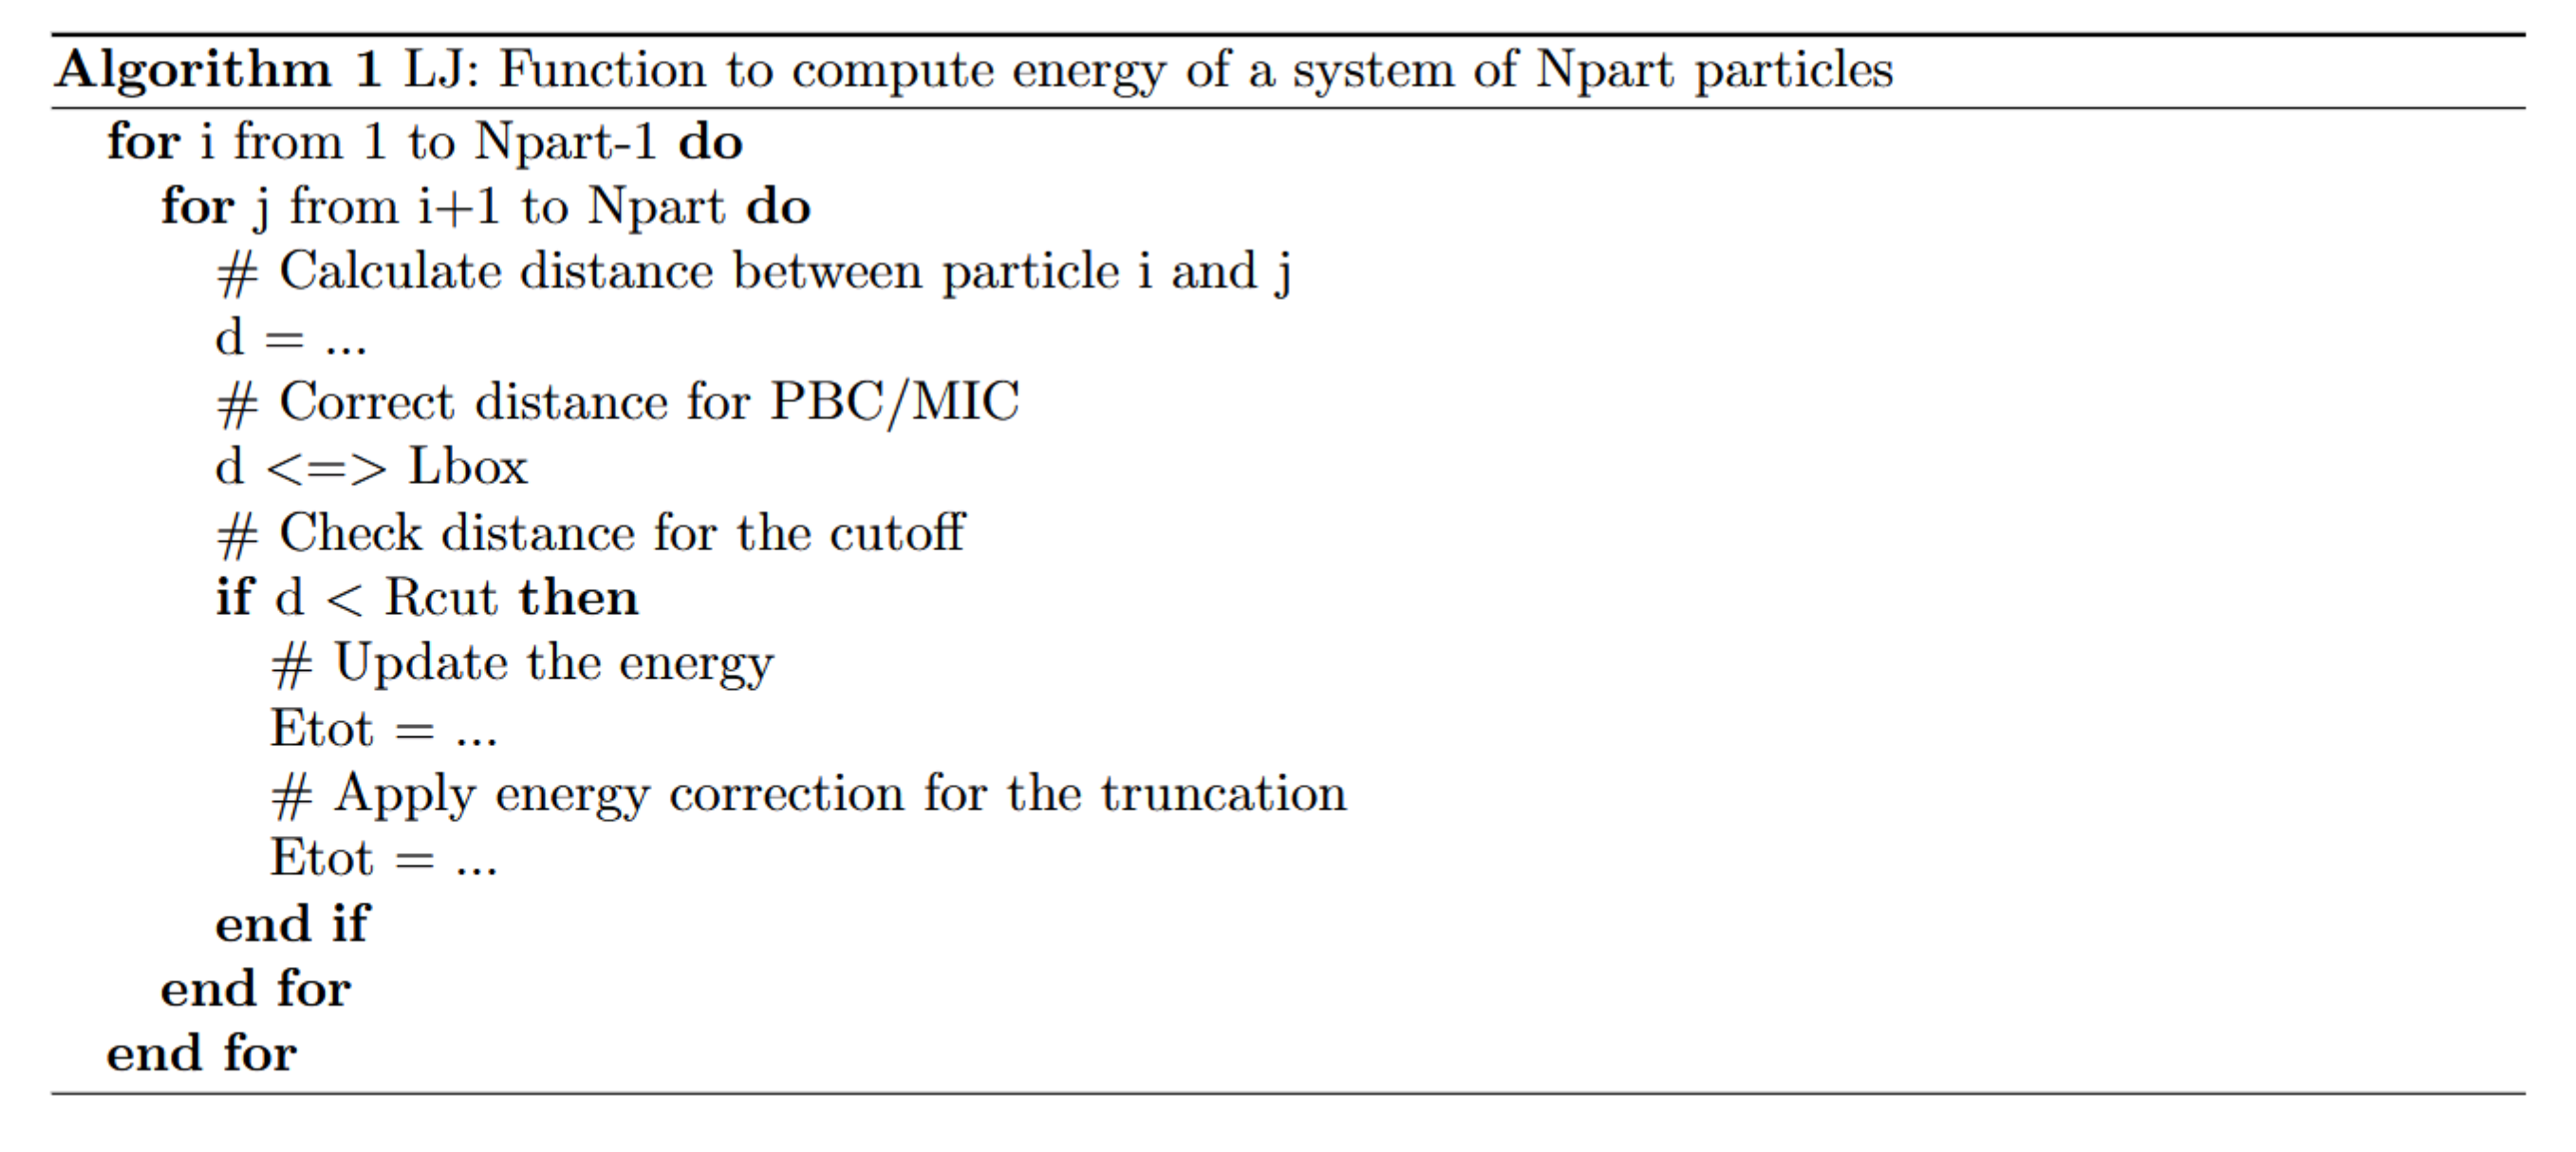

### Answer 1.1

**<p>Massimiliano Toffoli -- 10/05/2025 </p>**
<em>
<span style="color:Lightgreen">
In the following code, first the "box.xyz" file is being openend as a pandas dataframe and converted into an numpy array. In order to properly read the data, it is necessary to skip the first two lines and the first column (column 0). For debugging purposes two prints were introduced to check whether the data was correctly imported.

<p>Moreover, the total energy function will be described in the following lines. </p>
<p>First all the varibles are initialized, then the function goes into a nested loop to then calculate the distance between the particles. In order to really get the shortest distance between the particles, the periodic boundary condition is applied by rounding the ratio of the calculate distance divided by the box lenght to the closest natural number. Afterwards, the module of the distance vector is calculated.</p>

<p>In order to calculate the Lennard-Jones potential, a Rcut needs to be defined. Rcut was set to 2.5 sigma, using the Lennart Jones Potential Diagram at slide 45 of Lecture 2, as the Potential is almost zero at r/sigma = 2.5. if r is smaller than Rcut the potential is being calculated. Moreover, the condition of Rcut > 1e-12 (a really small value close to zero) was implemented in order to avoid divisions by zero.  In the following line the total energy gets then updated.</p> 

<p>Because a cut off condition was implemented, it is necessary to also add the "remaining" energy that wasn't considered, in this case called as the tail energy. This is being calculated and then added to the total energy at the end of the nested loop. The function is now complete.</p>

<p>After calling the function the following value was obtained = -4.365138172296742e-18 J, a sanity check was done, to check whether the solutions was plausible or not. Since there's attraction between the particles the energy should be negative, which is reflected in the final result. Moreover, having 362 particles we can excpect around 362*361/2 = 65000 interactions, which means that we can expect our energy to be of the order of magnitude of thousands of epsilon, just like in this case.</p> 
</span>.

</em>


In [4]:
# Massimiliano Toffoli -- 10/05/2025
# total energy function

#get the positions of the particles from the box.xyz file:

pos = pd.read_table("box.xyz", skiprows=2, delim_whitespace= True, usecols=[1, 2, 3], names=['x', 'y', 'z']).to_numpy() #read the file and save the positions in the np.array
pos = pos * 1e-10 #convert the positions from Angstrom to meters

#print(pos.shape)  for debugging purposes to check the shape of the array
#print(pos[:5]) for debugging purposes to check the first 5 lines of the array

#start energy function
def totalEnergy(pos: np.ndarray) -> float: #value that is returned is a float, input is a numpy array
    
    # Variables needed for this function
    sigma = 3.73*10 ** (-10) #sigma in meters
    epsilon = 148 * 1.38 * 10 ** (-23) #calculate epsilon in J
    Lbox = 30 *10**(-10) #Lenght of the cubic box in meters
    Rcut = 2.5 * sigma #cutoff radius (see explanation from above)
    Energy_tot = 0.0 #initialize the total energy
    energy = 0.0 #initialize the energy
    V = Lbox ** 3 #volume of the box in m^3
    N = pos.shape[0] #number of particles
    M = 16.04 * 10 ** (-3) #molar mass of the system in kg/mol 
    rho = (N) / (V) #density of the system

    #start looping over the particles
    for i in range(0,N-1):
        for j in range(i+1,N):
            dr = pos[i] - pos[j] #calculating the distance between the particles
            dr = dr - Lbox * np.round(dr / Lbox) #apply periodic boundary conditions
            r = np.sqrt(np.sum(dr**2)) #Module of the distance

            if r < Rcut and r >1e-14 : #condition where the Lennard-Jones potential is calculated, added condition to avoid division by zero 
                # calculate the Lennard-Jones potential
                energy = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
                Energy_tot = Energy_tot + energy #calculate the total energy

   
    energy_tail = N * 8/3 *np.pi * rho * epsilon * sigma**3 *(1/3 *(sigma/Rcut)**9 - (sigma/Rcut)**3) # calculate total tail energy        
    Energy_tot = Energy_tot + energy_tail #calculate corrected total energy

   
    return Energy_tot

#start code 
N = pos.shape[0] #number of particles
NA = sc.Avogadro #Avogadro's number in mol^-1
Energy_tot = totalEnergy(pos)
Energy_tot = (Energy_tot/N) * NA #conversion from Joules to Joules/mol
print("Total energy of the system is: ", Energy_tot , "J/mol") #print the total energy of the system



C:\Users\seven\AppData\Local\Temp\ipykernel_18140\2429389175.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pos = pd.read_table("box.xyz", skiprows=2, delim_whitespace= True, usecols=[1, 2, 3], names=['x', 'y', 'z']).to_numpy() #read the file and save the positions in the np.array


Total energy of the system is:  -5988.475769386259 J/mol


### Question 1.2
Write a function (named "**singleParticleEnergy**") that returns the energy of one particle in a box. Use the function that is used to compute the total energy as a starting point and modify it appropriately.

### Answer 1.2
**<p>Massimiliano Toffoli -- 12/05/2025 </p>**
<em>
<span style="color:Lightgreen">
<p>In order to calculate the energy of one particle in a box, it is possible to reuse the previous function and slightly modify it. First of all it is necessary to remove the outer loop (since now we are calculating the energy of 1 particle) and to add an if condition to avoid self interaction. Moreover also the tail correction needs to be updated, since we are accounting for only 1 particle.</p>
<p>Finally, to validate the result, the energy of one particle (–39.42 J/mol) is compared to the total energy computed in Question 1.1 (–7261.73 J/mol). Since the ratio is approximately 1/184, which is of the same order as 1/362, the result is considered physically plausible. Slight deviations are expected due to local variations in particle surroundings.</p>
</span>.

</em>


In [5]:
# Massimiliano Toffoli -- 12/05/2025
# single energy function
@njit(parallel = True) #try with paralleization
def singleParticleEnergy(pos: np.ndarray, particle_index: int, Rcut,sigma) -> float:
    
    epsilon = 148 * 1.38 * 10 ** (-23) #converts epsilon Joules
    Lbox = 30 *10**(-10) #Lenght of the cubic box in meters
    Energy_particle = 0.0 #initialize the total energy per pparticle
    V = Lbox ** 3 #volume of the box in m^3
    N = pos.shape[0] #number of particles 
    rho = (N) / (V) #density of the system

    dr = pos - pos[particle_index] #calculating the distance between the particles in a vectorized form by using the broadcasting feature of numpy
    dr = dr - Lbox * np.round(dr / Lbox) #apply periodic boundary conditions
    r = np.sqrt(np.sum(dr**2,axis=1)) #module of the distance

    mask = (r < Rcut) & (r > 1e-14) #condition where the Lennard-Jones potential is calculated, added condition to avoid division by zero  and avoids same particle which has dr=0
    
    r_accepted = r[mask]
    Energy_particle = np.sum(4 * epsilon * ((sigma / r_accepted) ** 12 - (sigma / r_accepted) ** 6))  # calculate the Lennard-Jones potential
    

    energy_tail = 1 * 8/3 *np.pi * rho * epsilon * sigma**3 *(1/3 *(sigma/Rcut)**9 - (sigma/Rcut)**3)   #tail correction for one particle         
    Energy_particle = Energy_particle + energy_tail #calculate corrected total energy


   
    return Energy_particle

N = pos.shape[0] #number of particles
NA = sc.Avogadro #Avogadro's number in mol^-1
particle_index = 2 #index of the particle for which we want to calculate the energy
sigma = 3.73*10 ** (-10) #convert sigma in meters
Rcut = 2.5 * sigma #cutoff radius (see explanation from above)
Single_energy_particle = singleParticleEnergy(pos,particle_index, Rcut,sigma)
Single_energy_particle = (Single_energy_particle/N) * NA #conversion from Joules to Joules/mol
print("The Energy of the particle is: ", Single_energy_particle , "J/mol") #print the total energy of the system

The Energy of the particle is:  -31.197335681652742 J/mol


### Question 1.3
Modify the totalEnergy function to return also the virial pressure. The virial pressure has an ideal gas contribution and a contribution due to the interactions of the particles in the system, 

$$
P = \rho k_B T - \frac{1}{3V} \langle \sum_{i<j} r_{ij} (\frac{dU(r_{ij})}{dr}) \rangle
$$

where $P$ is the virial pressure, $k_B$ is the Boltzmann constant, $\rho$ is the number density of the system, $V=L_{box}^3$ is the volume of the simulation box and $U(r_{ij})$ is the interaction potential. For particles interacting via the Lennard-Jones potential, find the expression for the virial pressure and add the expression to functions where energy is computed.

You can either write an observables function which computes the total energy and the pressure together, or a separate pressure function. Note that both functions need the distances between all particles.

### Answer 1.3
**<p>Massimiliano Toffoli -- 12/05/2025 </p>**
<em>
<span style="color:Lightgreen">
<p>This function resembles again the total energy function. In order to calcolate the virial pressure, the derivative of the Lennard-Jones potential, multiplied by the modulus r has to be calculated first in the nested loop. Afterwards, the virial pressure can be calculated with the formula presented above.</p>
<p> In order to validate the result of the virial pressure, the NIST database was used. Here, for Methane, at 150K and a density of around 22264 mol/m^3 a value of 5 MPa is recorded. This is more than a 1/10 of the simulation result. These descripancies could be explained through the fact that the used model is a simplification of reality and some molecular effects are not considered. </p>

<p>Moreover the nested loops where changed in order to reduce calculation times in question 1.6, this was done by using the broadcasting feature of numpy and thus vectorizing the results, and having the advantage of using the C++ code present in these arrays.</p>
</span>
<span style="color:Red"> Correction needed! </span>

</em>

In [7]:
# Massimiliano Toffoli -- 12/05/2025
# pressure function

def observables(pos: np.ndarray, Lbox, Rcut,sigma) -> tuple[float, float]:

    # Variables needed for this function
    epsilon = 148 * sc.k #converts epsilon Joules
    Energy_tot = 0.0 #initialize the total energy
    energy = 0.0 #initialize the energy
    SumDu_dr = 0.0 # Sum of the r Du/dr term
    virial_pressure = 0.0 #initialize the virial pressure
    Kb= sc.k #Boltzmann constant in J/K
    T = 150 #temperature in Kelvin
    V = Lbox ** 3 #volume of the box in m^3
    N = pos.shape[0] #number of particles
    M = 16.04 * 10 ** (-3) #molar mass of the system in kg/mol 
    rho = (N) / (V) #density of the system

    
    dr =  pos[:, np.newaxis, :] - pos[np.newaxis, :, :] #calculating the distance between the particles in a vectorized form by using the broadcasting feature of numpy
    dr = dr - Lbox * np.round(dr / Lbox) #apply periodic boundary conditions
    r = np.sqrt(np.sum(dr**2,axis=2)) #module of the distance

    mask = (r < Rcut) & (r > 1e-14) #condition where the Lennard-Jones potential is calculated, added condition to avoid division by zero 
    
    r_accepted = r[mask]
    energy = 4 * epsilon * ((sigma / r_accepted) ** 12 - (sigma / r_accepted) ** 6)  # calculate the Lennard-Jones potential
    dU_dr = r_accepted*(-24 * epsilon * (2 * sigma**12 / r_accepted**13 - sigma**6 / r_accepted**7)) # derivative of the Lennard-Jones potential
    SumDu_dr = np.sum(dU_dr)/2 # sum of the derivative * rij
               
    Energy_tot = np.sum(energy)/2 #calculate the total energy, divide by 2 to avoid double counting
    
    #calculate the virial pressure
    energy_tail = N * 8/3 *np.pi * rho * epsilon * sigma**3 *(1/3 *(sigma/Rcut)**9 - (sigma/Rcut)**3)  #tail correction          
    Energy_tot = Energy_tot + energy_tail #calculate corrected total energy
    virial_pressure = rho*Kb*T - 1/(3*V) * (SumDu_dr) #calculate the virial pressure
   
    return Energy_tot, virial_pressure

#start code 

N = pos.shape[0] #number of particles
NA = sc.Avogadro #Avogadro's number in mol^-1
Lbox = 30 *10**(-10) #Lenght of the cubic box in meters
sigma = 3.73*10 ** (-10) #convert sigma in meters
Rcut = 2.5* sigma #cutoff radius (see explanation from above)
Energy_tot, pressure = observables(pos, Lbox,Rcut, sigma)
Energy_tot = (Energy_tot/N) * NA #conversion from Joules to Joules/mol
print("Total energy of the system is: ", Energy_tot , "J/mol") #print the total energy of the system
print("The virial pressure is: ", pressure *(10**(-6))  , "MPa") #print the total energy of the system





Total energy of the system is:  -5991.292088787946 J/mol
The virial pressure is:  19.62930825258891 MPa


### Question 1.4
Write a function (named "**translate**") that performs translational trial moves. Use the following algorithm:

1. **Select a Particle**  
   Randomly choose a particle in the simulation box.

2. **Apply a Random Displacement**  
   Displace the particle randomly in each Cartesian direction:
   $$x_n = x_o + Δ$$
   $$y_n = y_o + Δ$$
   $$z_n = z_o + Δ$$
   Where:
   - $x_n$, $y_n$, $z_n$: new coordinates
   - $x_o$, $y_o$, $z_o$: original coordinates
   - $Δ$: a uniformly distributed random number in:
     - $[-Δx, +Δx]$ for $x$
     - $[-Δy, +Δy]$ for $y$
     - $[-Δz, +Δz]$ for $z$

3. **Apply Periodic Boundary Conditions**  
   If the new coordinates fall outside the simulation box, wrap them around using periodic boundary conditions.

4. **Compute Energies**  
   - Compute the single particle energy $U_o$ of the particle at the original position $r_o$.
   - Compute the single particle energy $U_n$ of the particle at the new position $r_n$.

5. **Compute Energy Difference**  
   Calculate the energy difference:
   $$ ΔU = U_n - U_o $$

6. **Metropolis Acceptance Criterion**  
   Decide whether to accept the move:
   $$acc(o → n) = min(1, \exp[-β ΔU])$$
   where $β = 1 / (k_B T)$, with $k_B$ being the Boltzmann constant and $T$ the temperature.

7. **Update Position**  
   - If the move is accepted, update the particle’s position to $r_n$.
   - If the move is rejected, keep the position as $r_o$.


Note that the values for the displacements in each direction are independent from each other. The value of $\Delta$ directly affects the number of accepted and rejected moves in MC simulations see *Monte Carlo Methods* in Allen & Tildesley, Computer Simulation of Liquids. If the maximum displacement is too small the move will almost always be accepted, but it will be that $U_{o}\approx U_{n}$. This means that the system will not change much. On the other hand, if the maximum displacement is very large it will be that $\beta \times [U_{o}-U_{n}]\gg 1$. Thus, the acceptance ratio will be very low and again the system will not change much. The rule of thumb is that a maximum displacement distance is considered good if the rate of acceptance of tranlational moves is 20 to 50 $\%$. At low densities, usually a large fraction moves is accepted, so the maximum displacement should be limited to half the boxsize.

TIP 1: You can start by restricting $\Delta$ to be a random number between -0.5 and 0.5 Å. This means that the maximum allowed displacement in any direction is 0.5 Å. By trial and error you can identify the optimum value for $\Delta$.
   
TIP 2: You can use the random number generator "random" from the package numpy in python to get random numbers when needed. This is also vectorized, getting 3 values (for 3 dimensions) should not take more lines of code than only getting 1 random value.

TIP 3: The min in $acc(o → n) = min(1, exp[-β ΔU])$ is meant for mathematicians, not for coding. Mathematically speaking if $\Delta U$ get negative you will always accept. Some trial moves will get a very negative $\Delta U$, this can result in an overflow warning in python. Typically, it is smarter to handle the case where $\Delta U \leq 0$ (always accept no need to draw a random number) separately from $\Delta U > 0$ (you need to draw a random number and do your comparison).

TIP 4: If you are not carefull you will "*mutate*" your position vector of all your attoms. This would mean that although you called pos_trial differently than your origional position vector in practice they point to exactly the same memory location. This might be the case if you always find a $\Delta U = 0.0$. In that case, you should look up the difference between a *deep copy* and a *shallow copy*.

_Reference: Chapter "Monte Carlo Methods" in Allen & Tildesley, *Computer Simulation of Liquids*._


### Answer 1.4
**<p>Massimiliano Toffoli -- 14/05/2025 </p>**
<em>
<span style="color:Lightgreen">
<p>In order to code the function which translates the position of a certain particle it is necessary to first choose a random particle with the np.random function. Once we know the position of our random particle we can go into our translate function. Here we define the maximum displacement for the x,y and z coordinates (here 0.5 Angstrom for all 3). In order to calculate the random displacement a random array with size 3, which goes from -1,1 is multiplied to the the 3 single displacements. By doing so we obtain a random displacement for each coordinate. </p>
<p> The displacement is then applied to the new position and then the periodic BC is applied, in order to ensure that the particle will stay inside the boundaries of our box. After this step the old and new single particle energy is being calculated. </p>
<p>In order to check whether the move of the particle can be accepted an additional check is needed: If the difference in Energy is negative or equal to zero, the step will be always accepted, since it's statistically favored. For the other case when dU is >0 then this case is less favorable, but it can be still accepted with the probability of exp (-Beta*dU), which is compared to a random number from 0 to 1 (generated by using np.random.rand).</p>

<p>If the move is accepted, the position is updated.</p> <p>In order to speed up the function, the code was optimized by avoiding fullarray copies and instead working directly with a single particle's position. Only the selected particle is temporarily stored and updated, which significantly reduces calculation times and memory usage.</p>
</span>.

</em>


In [8]:
# Massimiliano Toffoli -- 14/05/2025
# translate function to perform a trial move

def translate(pos: np.ndarray, random_particle, Lbox, Delta, Rcut,sigma) -> tuple[np.ndarray, bool]:

    dU = 0.0 #initialize the energy difference
    Kb= 1.38 * 10 ** (-23) #Boltzmann constant in J/K
    T = 150 #temperature in Kelvin
    beta = 1 /(Kb*T)
    pos_old = pos.copy() # define old position
    dx,dy,dz =  Delta*10**(-10), Delta*10**(-10), Delta*10**(-10) #displacement in x,y,z direction in meters
    displacement = np.random.uniform(-1, 1, size=3) * np.array([dx, dy, dz]) # random displacement in all 3 directions from -dx to dx, -dy to dy and -dz to dz

    pos [random_particle] = pos_old [random_particle] + displacement # new position of the particle

    pos[random_particle] = pos[random_particle] - Lbox * np.round(pos[random_particle] / Lbox) #apply periodic boundary conditions

    U_old = singleParticleEnergy(pos_old,random_particle, Rcut,sigma ) #calculate the energy of the old position
    U_new = singleParticleEnergy(pos,random_particle, Rcut,sigma ) #calculate the energy of the new position
    dU = U_new - U_old #calculate enrrgy difference

    if dU <= 0:
        accepted = True
    else:
        acc = np.exp(-beta * dU)
        accepted = np.random.rand() < acc
    
    if accepted != True:
        pos[random_particle] = pos_old[random_particle] #if the move is not accepted, set the position back to the old position
       


    return pos, accepted

random_particle = np.random.randint(pos.shape[0]) #randomly select a particle
Delta = 0.5 #displacement in Angstroms
Lbox = 30 *10**(-10) #Lenght of the cubic box in meters
sigma = 3.73*10 ** (-10) #convert sigma in meters
Rcut = 2.5 * sigma #cutoff radius 
new_pos, accepted = translate(pos, random_particle, Lbox, Delta, Rcut, sigma) 
print("The new position of the particle is: ", new_pos[random_particle]) #print the new position of the particle

The new position of the particle is:  [-1.41510450e-09  1.30050680e-09  7.21275702e-10]


### Question 1.5
Write a function ("**startConf**") that provides a random starting configuration for your simulation. The function should assign random positions to a number, $N_\text{part}$, of particles inside a cubic box with side length $L_\text{box}$. Provide a configuration without any particles overlapping. This is achieved by performing MC cycles in which particles are displaced randomly. To achieve a proper initial configuration, it is recommended to perform $N_\text{init}= 50 \times N_\text{part}$ translational moves. After assigning random positions (stored in the array $r$) to all particles, the translational moves implemented in question 1.4 can be utilized to remove overlaps from your system.

To test your function try to recreate the original box given ("*box.xyz*") by using the following parameters:
- $N_\text{part}=362$
- $\rho=358.4$ kg m<sup>-3</sup>

Combining this should result in a box size about $L_\text{box}=30$ Å.

### Answer 1.5
**<p>Massimiliano Toffoli -- 15/05/2025 </p>**

<em>
<span style="color:Lightgreen">
First, a sample of random N-particles inside the box domain is being generated. In order to avoid particle overlapping the function chooses a random particle to translate (by using the function from the previous question). Moreover the acceptance rate is being uodated: if the move was accepted it will increase the number of accepted moves.</p>
Moreover, at the end the acceptance ratio is being calculated.
With these functions an acceptance rate of 37.93% was obtained in a box with a lenght of 29.96Angstrom.
<p>It has to be noted, that thanks to the improvement in terms of array handling, which was done in the coding process of the previous question, the calculation time of around 18000 translational move was just over a minute.</p>

</span>.

</em>

In [9]:
# Massimiliano Toffoli -- 15/05/2025
# starting configuration function

def startConf(nParticles: int, density: float, nEquilibrate: int, Delta, Rcut, sigma) -> tuple[np.ndarray, float]:
    Naccepted = 0 #initialize the number of accepted moves
    NA = sc.Avogadro #Avogadro's number in mol^-1
    M = 16.04 * 10 ** (-3) #molar mass of CH4 in kg/mol
    V = nParticles * M / (density * NA) #volume of the box in m^3
    Lbox = V ** (1/3) #length of the box in m
    positions = np.random.uniform (0, Lbox, size=(nParticles, 3)) #randomly generate the positions of the particles in the box, np.random.uniform will generate sample which are uniformly distributed
    for i in range(nEquilibrate):
        random_particle = np.random.randint(positions.shape[0]) #choose a random particle
        positions, accepted = translate(positions, random_particle, Lbox, Delta,Rcut,sigma)
        if accepted == True:
            Naccepted = Naccepted + 1 #if the move is accepted, increase the number of accepted moves
    
    Naccepted = Naccepted / nEquilibrate #calculate the acceptance ratio
        
    return positions, Lbox, Naccepted

rho = 358.4 # density in kg/m^3
N = 362 # number of particles
Delta = 0.5 #displacement in Angstroms
Nequilibrate = 50*N # number of equilibration steps
sigma = 3.73*10 ** (-10) #convert sigma in meters
Rcut = 2.5 * sigma
pos, Lbox, Naccepted = startConf(N, rho, Nequilibrate, Delta, Rcut,sigma) #start configuration
print("The length of the box is: ", Lbox * 1e10, "Angstrom") #print the length of the box in Angstrom
print("The acceptance ratio is:", Naccepted*100, "%") #print the length of the box in Angstrom


The length of the box is:  29.96387732565768 Angstrom
The acceptance ratio is: 42.33701657458563 %


### Question 1.6
Write a function (named "**averages**") to sample averages. At each MC cycle this function will be called (using the energy and virial pressure of the current configuration of the system) to return the updated average total energy and average total virial pressure.

Tip 1: Remember that all moves should be take into account when performing the ensemble average, even the rejected ones.  
Tip 2: Running averages or thinks like that are not required. However you should be able to provide an average value and an appropriate uncertainty interval of your result. Make sure to report what certainty range (for example 95% confidence interval) you are using in your results.  
Tip 3: If you want to report moving averages like behaviour we advice to use the pandas package to compute a gaussian moving average window for your results. You could add this to the functionality of the averages function if you want to.

### Answer 1.6
**<p>Massimiliano Toffoli -- 18/05/2025 </p>**

<em>
<span style="color:Lightgreen">
In this question, first a starting configuration is defined by using the function startconf. Then for that configuration over a number of cycles nCycles a random particle is chosen, moved (if accepted) and then through the observables function the Energy and pressure is being calculated. Finally, through the averages function the mean energy, pressure and uncertainty (with 95% confidence interval) is being calculated and returned.
<p>A test run of 1000 iterations was done, order to test computing perfomance.</p>

</span>

</em>

In [10]:
# Massimiliano -- 19/05/2025
# averages function

def averages(energies, pressures) -> tuple[float, float,float,float]:

    mean_energy = np.mean(energies)    #calulate the mean energy
    mean_pressure = np.mean(pressures) #calculate the mean pressure
    uncertainty_energy = 1.96 * np.std(energies) / np.sqrt(len(energies))  #uncertainty of the mean with 95% confidence interval
    uncertainty_pressure = 1.96 * np.std(pressures) / np.sqrt(len(pressures)) 
    
    return mean_energy, mean_pressure, uncertainty_energy, uncertainty_pressure

#start code
rho = 358.4 # density in kg/m^3
N = 362 # number of particles
Nequilibrate = 50*N # number of equilibration steps
Delta = 0.5 #displacement in Angstroms
sigma = 3.73*10 ** (-10) #convert sigma in meters
Rcut = 2.5 * sigma 
pos, Lbox, Naccepted = startConf(N, rho, Nequilibrate, Delta, Rcut,sigma) #start configuration
energies = []
pressures = []
nCycles = 10000 #number of cycles
for i in range(nCycles):
    random_particle = np.random.randint(pos.shape[0]) #choose a random particle
   
    new_pos, accepted = translate(pos,random_particle,Lbox, Delta, Rcut,sigma)  #use the translate function to move the particle
    

    E,P = observables(new_pos, Lbox, Rcut,sigma) #calculate the pressure and Particle of the particle
    energies.append(E)
    pressures.append(P)


mean_energy, mean_pressure, uncertainty_energy, uncertainty_pressure = averages(energies, pressures) #calculate the mean and uncertainty of the energies and pressures
print("The mean energy is: ", mean_energy*(NA/N) , "+-", uncertainty_energy*(NA/N), "J/mol" ) 
print("The mean pressure is: ", mean_pressure*10**(-6) , "+-", uncertainty_pressure*10**(-6), "MPa" ) 

The mean energy is:  -5843.50430810165 +- 1.2307468608149703 J/mol
The mean pressure is:  61.47311624108076 +- 0.21473215058853048 MPa


### Question 1.7
Write the full MC program (named "**MC_NVT**") using the functions you have already created before. The basic skeleton is given below. Keep in mind that uncertainties can only be computed from the standard deviation if the samples are uncorrelated. You can perform complicated mathematics to check if your results are uncorrelated, however a simple solution also exists. A single trial move will not result in a particularly new observable value. Therefore, it might be smarter to only sample your observables (pressure and totalEnergy) only every $N_\text{spacing}$ trial moves. This makes your results not only noncorrelated but also your computation less expensive. Finding the correct $N$ is off-course your own task.

Tip 1: To complete question 2 and 3 with no change to your code, you would want to return the following properties:
- average and uncertainty pressure
- average and uncertainty total energy
- acceptance rate
- pressure full array (either raw pressure values or a moving average)
- total energy full array (either raw pressure values or a moving average)
Tip 2: Question 2 and 3 require different input vales. For question 2 you would need to compute the number of atoms, as that assignment provides the box size and the density. To complete question 3 with no changes to you code, you should create an initial simulation box with the input number of atoms and density. We advise that you implement the code for question 3 in your MC_NVT function and just calculate the number of atoms for assingment 2 beforehand, which you can then input with the density into MC_NVT. MC_NVT should then compute the box size again that the assignment provides so you can use that as sanity check.

### Answer 1.7
**<p>Massimiliano Toffoli -- 19/05/2025 </p>**

<em>
<span style="color:Lightgreen">
<p> In this function first a starting configuration is created with the function startConf. Then two for loops are used to loop over the number of cycles and over nspacing, which is used to sample the energy values only after Nspacing trial moves (by using the translate function). Finally the acceptance rate is being calculated and the mean energy and pressure and their uncertainties are being calculated by using the averages function. The final result is then being returned.</p>

<p>In order to run 500k iterations Ncycle was set to 500 and Nspace was set to 1000, by doing so 500 uncorrelated datapoints would be collected.</p>

</span>

</em>

In [13]:
# Massimiliano Toffoli -- 19/05/2025
# main MC function


def MC_NVT(nParticles: int, density: float, nEquilibrate: int,
           nCycle: int, nSpacing: int, Delta, Rcut,sigma) -> tuple[float, float, float, float, float, np.ndarray, np.ndarray]:
 
    
    # get initial configuration
    pos, Lbox, moves_accepted = startConf(nParticles, density, nEquilibrate, Delta, Rcut,sigma)    # last variable is not used in the function, but helps for debugging
  
    pressures = np.zeros(nCycle)
    energies  = np.zeros_like(pressures)
    tries = 0
    Naccepted = 0
    acc_rate = 0.0  
    for i in range(nCycle):
        for _ in range(nSpacing):
            random_particle = np.random.randint(pos.shape[0]) #choose a random particle
            
            new_pos, accepted = translate(pos,random_particle,Lbox, Delta, Rcut,sigma)  #use the translate function to move the particle
            if accepted == True:
                Naccepted = Naccepted + 1 #if the move is accepted, increase the number of accepted moves
                pos = new_pos #update the position of the particle
          
            tries = tries + 1 
        # compute the observables
        energies[i], pressures[i] = observables(pos, Lbox, Rcut,sigma)
        
    # compute averages
    acc_rate = Naccepted / tries
    mean_energy, mean_pressure, uncertainty_energy, uncertainty_pressure = averages(energies, pressures) #calculate the mean and uncertainty of the energies and pressures
    
    
    return mean_pressure, mean_energy, uncertainty_pressure, uncertainty_energy, acc_rate, pressures, energies, Lbox

Nparticles = 362 # Number of particles
rho = 358.4 # Density in kg/m^3
Nequilibrate = 50 * Nparticles # Number of equilibration steps
nCycle = 500 # Number of cycles
NA = sc.Avogadro #Avogadro's number in mol^-1
nSpacing = 1000 # Number of cycles between each observables calculation
Delta = 0.5 # Displacement in Angstroms
sigma = 3.73*10 ** (-10) #convert sigma in meters
Rcut = 2.5 * sigma #cutoff radius 
Rcut = 14 * 10 ** (-10) #cutoff radius in meters
pm, em, pu, eu, acc_rate, pressure, energy, Lbox = MC_NVT(Nparticles, rho, Nequilibrate, nCycle, nSpacing, Delta, Rcut,sigma) #start configuration
print("The mean energy is: ", em* (NA/Nparticles) , "+-", eu*(NA/Nparticles), "J/mol" )
print("The mean pressure is: ", pm*10**(-6) , "+-", pu*10**(-6), "MPa" )
print("The acceptance ratio is:", acc_rate*100, "%") #print the length of the box in Angstrom


The mean energy is:  -5972.711552723137 +- 4.792947897334978 J/mol
The mean pressure is:  10.463954346093972 +- 0.702862826805469 MPa
The acceptance ratio is: 46.8786 %


## Assignment Part 2: Application of the MC_NVT Code
Use the [United-Atom TraPPE force field](http://chem-siepmann.oit.umn.edu/siepmann/trappe/index.html) for CH<sub>4</sub>: LJ parameters: $\sigma = 3.73$ Å and $\epsilon/ k_B = 148$ K. In all Questions use a truncated potential with analytic tail corrections. These questions require extensive answers and intepretations of the results. Do not forget to provide textual explanations.

Before you implement assignment 2 and 3, you could create a separate `assignment1.py` file to which you copy all your functions. Then you could implement an input parser so you can call you python code from the terminal. As already indicated before, our example still misses some inputs but you can figure that out yourself.

```python
import sys
import pandas

def main():
    # Expected 5 arguments + 1 for script name
    if len(sys.argv) != 6:
        print("Usage: python code.py <nParticles> <density> <nInitCycle> <nCycle> <nSpacing>")
        sys.exit(1)

    errors = []

    # Individual parsing with detailed error tracking
    try:
        nParticles = int(sys.argv[1])
    except ValueError:
        errors.append(f"Invalid nParticles: expected an integer, got '{sys.argv[1]}'.")

    try:
        density = float(sys.argv[2])
    except ValueError:
        errors.append(f"Invalid density: expected a float, got '{sys.argv[2]}'.")

    try:
        nInitCycle = int(sys.argv[3])
    except ValueError:
        errors.append(f"Invalid nInitCycle: expected an integer, got '{sys.argv[3]}'.")

    try:
        nCycle = int(sys.argv[4])
    except ValueError:
        errors.append(f"Invalid nCycle: expected an integer, got '{sys.argv[4]}'.")

    try:
        nSpacing = int(sys.argv[5])
    except ValueError:
        errors.append(f"Invalid nSpacing: expected an integer, got '{sys.argv[5]}'.")

    # If there were any parsing errors, print and exit
    if errors:
        print("\nErrors detected:")
        for error in errors:
            print(" -", error)
        sys.exit(1)

    # Output the collected variables
    print("\nCollected Inputs:")
    print(f"nParticles: {nParticles}")
    print(f"density: {density}")
    print(f"nInitCycle: {nInitCycle}")
    print(f"nCycle: {nCycle}")
    print(f"nSpacing: {nSpacing}")

    pm, pu, em, eu, acc_rate, pressure, energy = MC_NVT(nParticles, density, nInitCycle, nCycle, nSpacing)

    # create a pandas dataframe
    # save the dataframe as a file


if __name__ == "__main__":
    main()
```
Instead of sys.argv, you can also use the default python packages `argparse`. It does nearly the same, however has some default implementations for standardised error messages ect.

Runnin the code trhough the terminal afterwards has at least the upsides:
1. Now you save the results in a file, so your results don't dissapear (maybe you should make a filename also an input parameter so that you won't overwrite a file after starting your next MC simulation :) ).  
2. Your python code will be a bit faster, it will cache a sort of compiled version of you python code after the first run. Which will then run faster.
3. You can search up how to call python code in the background from a jupyter notebook. Then you can run MULTIPLE MC simulations at the same time. This doesn't make your program really parallel, but it will speed up the time you wait for multiple simulations by a lot. Note that if you have lets say 8 cores, it will make no sense for launching more than around 7 or 8 MC simulations at the same time. Reflect in your report why this whould be the case.

### Question 2.1
Assume a temperature $T=150$ K and a density $\rho=358.4$ kg m<sup>-3</sup>. Check if your cubic box has side lengths $L \approx 30$ Å and set the cutoff distance of 14 Å. Run the MC simulation for 500,000 cycles and provide a plot of the rate of acceptance as a function of the different maximum displacements tested. What value would you choose as a maximum displacement for this simulation based on the results?

**<p>Massimiliano Toffoli -- 27/05/2025 </p>**

<em style="color:Lightgreen">
<span> 
<p></p>
<p>Instead of using the method above, for simplicity the values of multiple deltas are being stored in a dictionary, which is then converted in a pandas dataframe. This is then converted and saved in a .csv file, which can be then used to compare the various simulation runs.</p><p>This is possible also due to the various optimizations that were done in part 1, which sped up the code, by doing so a simulation run for 20 Deltas take around 13-14 minutes.</p> 
<p>To answer the question above, in a 8 core system it wouldn't make sense to run more than 8 processes, as then the calculations would be divided again through the cores, thus losing the advtange of parallelization.</p>

</span>

</em>

In [ ]:
# Massimiliano Toffoli -- 27/05/2025
# Simulate trial move size versus acceptance rate

# Define the variables from the Jupyter Notebook
Nparticles = 362  
NA = sc.Avogadro # Avogadro's number
density = 358.4  # density in kg/m^3
nInitCycle = 50  # number of cycles to equilibrate the system *nParticles
nSpacing = 1000  # number of cycles to perform between each sample. Figure out what is appropriate for your simulation.
nCycle = int(500000/nSpacing)  # total number of cycles to run the simulation
Nequilibrate = nInitCycle * Nparticles  # total number of equilibration cycles
delta_list = np.linspace(0.1, 1.5, 10)  # Displacement values in Angstroms from 0.1 to 1.0 in 10 steps
Rcut = 14.0 * 10**(-10)  # Cutoff radius in meters
sigma = 3.73 * 10**(-10)  # Sigma in meters
results = []  # List to store results for each Delta value

for Delta in delta_list:
    pm, em, pu, eu, acc_rate, pressure, energy, Lbox = MC_NVT(Nparticles, rho, Nequilibrate, nCycle, nSpacing, Delta, Rcut,sigma) #start configuration
    #print("The mean energy is: ", em* (NA/Nparticles) , "+-", eu*(NA/Nparticles), "J/mol" )
    #print("The mean pressure is: ", pm*10**(-6) , "+-", pu*10**(-6), "MPa" )
    #print("The acceptance ratio is:", acc_rate*100, "%") #print the length of the box in Angstrom

    results.append( dict(
        dx       = Delta,
        acc_ratio  = acc_rate*100,
        P_MPa      = pm * 1e-6,
        P_err_MPa  = pu * 1e-6,
        E_Jmol     = em*(NA/Nparticles),
        E_err_Jmol = eu*(NA/Nparticles),
        Lbox = Lbox * 1e10,
    ) )


df = pd.DataFrame(results)
df.to_csv("Acc_vs_dx.csv", index=False)
display(df)

,dx,acc_ratio,P_MPa,P_err_MPa,E_Jmol,E_err_Jmol,Lbox
0,0.100000,86.1706,76.726440,24.095307,-5517.174894,219.030158,29.963877
1,0.255556,69.1268,16.780159,1.509143,-5940.800460,8.245888,29.963877
2,0.411111,54.1882,12.240172,0.785378,-5966.793441,4.892794,29.963877
3,0.566667,41.9406,10.302990,0.689853,-5979.375953,4.755954,29.963877
4,0.722222,32.3104,12.779922,0.681859,-5970.560423,4.847395,29.963877
5,0.877778,25.4330,10.472899,0.748961,-5974.027780,4.942120,29.963877
6,1.033333,19.8248,12.562111,0.683091,-5966.265683,4.594442,29.963877
7,1.188889,15.7308,10.994694,0.647028,-5976.618219,4.600842,29.963877
8,1.344444,12.6436,11.633253,0.739708,-5971.926759,5.413310,29.963877
9,1.500000,10.2118,11.331416,0.753747,-5977.629834,5.075334,29.963877


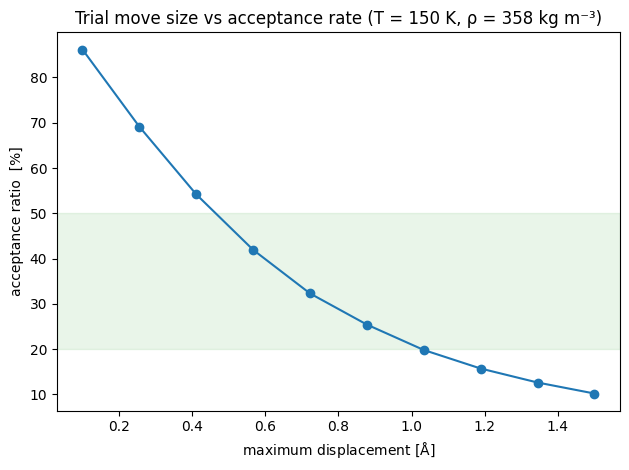

In [18]:
# Massimiliano Toffoli -- 27/05/2025
# Plot trial move size versus acceptance rate
plt.figure()
plt.plot(df["dx"], df["acc_ratio"], marker='o')
plt.axhspan(20,50, alpha=0.1, color='tab:green')   # window with an acceptable acceptance ratio
plt.xlabel(r"maximum displacement [$\mathrm{\AA}$]")
plt.ylabel("acceptance ratio  [%]")
plt.title("Trial move size vs acceptance rate (T = 150 K, ρ = 358 kg m⁻³)")
plt.tight_layout()
plt.show()
# Read the data from the files

# Some Plotting functions

## Question 2.2
previously you found the maximum displacement for a liquid system. How will the value of the maximum
displacement differ when studying gases? Try with methane at $T = 400$ K and $ρ = 9.68$ kg m<sup>-3</sup>. Assume a
cubic box with side lengths $L = 75$ Å and cutoff distance of $30$ Å. Provide a plot of the rate of acceptance
as a function of the different maximum displacements tested

### Answer 2.2
name -- timestamp  
answer to question 2.2

In [ ]:
# name -- timestamp
# Simulate trial move size versus acceptance rate

# similar to previous assignment.

In [ ]:
# name -- timestamp
# Plot trial move size versus acceptance rate

# Read the data from the files

# Some Plotting functions

## Question 2.3

For the liquid CH<sub>4</sub> system studied in Question 2.1, run the MC simulation for 500,000 cycles (using the
optimum maximum displacement) and plot the energy of the system as a function of the cycles. How
can you establish based on that plot that the system reached equilibrium? How many cycles does it take
for the system to reach equilibrium? Furthermore, report the average energy and the error of the energy
of the system.

## Answer 2.3
name -- timestamp  
answer to question 2.3


In [ ]:
# name -- timestamp
# Simulations for investigating equilibration

In [ ]:
# name -- timestamp
# plotting for investigating equilibration

# Assignment Part 3: Compute the P-T diagram of CH<sub>4</sub> using NVT MC

Now we gat to the main goal of our MC simulations, creating the PT-diagram of liquid and gaseous CH<sub>4</sub>. Think about the relevance of being able to model multiple phases of a material with only 2 parameters determining the behaviour of the material. Would you be able to do the same with equations of state?

## Question 3.1
Compute and report the isotherm (plot of pressure as a function of temperature) of CH4 at the following
densities and temperatures:
- $ρ = 358.4$ kg m<sup>-3</sup> at $T = 200$, $300$ and $400$ K, with 362 CH<sub>4</sub> molecules and a cutoff of $14$ Å.
- $ρ = 1.6$ kg m<sup>-3</sup> at $T = 200$, $300$ and $400$ K, with 362 CH<sub>4</sub> molecules and a cutoff of $50$ Å



The obtained results should be in agreement with the experimentally measured quantities. To check whether your simulation is close to reality, please visit the website of https://webbook.nist.gov/chemistry/fluid/ and choose the right settings to check your result. On this website you will find data for methane derived by Equations of state, which are based on experimental results. Plot your results (P-T curves along with
the NIST data). Remember that the quality of the force field (here TraPPE) is very important. You may observe deviations from the NIST data even if your MC code is correct. Alternative sources of methane density, such as scientific experimental results or well tested python packages for Equation of State model camn also be used.

TIP 1: Make sure that your system is equilibrated (see Question 2.3) and then start sampling averages.  
TIP 2: The time for each calculation depends on the computational power of your PC, the efficiency of the MC implementation and the system size. On a normal laptop one simulation can take up to approximately 1 hour. If your simulations take significantly longer it indicates that relevant optimisations are still possible. The best implementations we have seen take a few minutes per state point (though this should not be your target as those significantly changed the interparticle distance and trial move implementations).

## Answer 3.1
name -- timestamp  
answer to question 2.3

In [ ]:
# name -- timestamp
# Simulations for liquid state

In [ ]:
# name -- timestamp
# Simulations for gas state

In [ ]:
# name -- timestamp
# plotting the results and comparing with EoS.